In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os

# Subir tres niveles desde tfm/teams/lille/ hasta data/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.insert(0, project_root)

from database.connection import get_db_manager

In [2]:
# Configuration
TABLE_TYPE = 'domestic'
LEAGUES = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
SEASON = '1920'
MIN_MINUTES = 800

LILLE_COLORS = {
    'primary': '#E30613',
    'secondary': '#002244'
}

HEERENVEEN_COLORS = {
    'primary': '#0066CC',
    'secondary': '#FFFFFF'
}

DF_PLAYERS = [
    {'name': 'Gabriel Magalhães', 'search': 'Gabriel', 'pos': 'DF', 'team': 'Lille'},
    {'name': 'Sven Botman', 'search': 'Botman', 'pos': 'DF', 'team': 'Heerenveen'},
]

SAVE_PATH_BASE = "./gabriel_botman_radars/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
# Conexión BD
db = get_db_manager()

league_list_str = "', '".join(LEAGUES)
query = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_{TABLE_TYPE} p
WHERE p.league IN ('{league_list_str}')
AND p.season = '{SEASON}'
ORDER BY p.league, p.season DESC, p.team, p.player_name
"""

df_big5 = pd.read_sql(query, db.engine)

# Add extras (NED-Eredivisie)
query_extras = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_extras p
WHERE p.league = 'NED-Eredivisie'
AND p.season = '{SEASON}'
ORDER BY p.team, p.player_name
"""

df_extras = pd.read_sql(query_extras, db.engine)
db.close()

df_raw = pd.concat([df_big5, df_extras], ignore_index=True)

print(f"Extraídos: {df_raw.shape[0]} registros, {df_raw.shape[1]} columnas")
print(f"  Big 5: {df_big5.shape[0]} | Extras (NED): {df_extras.shape[0]}")
df_raw.head()

2026-01-09 19:13:17,538 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-09 19:13:19,455 - database.connection - INFO - Database connection successful


Extraídos: 3125 registros, 10 columnas
  Big 5: 2655 | Extras (NED): 470


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
0,528b83f69d55c8f1,Ainsley Maitland-Niles,Arsenal,ENG-Premier League,1920,DF,ENG,21.0,"{'FK': '0', 'OG': '0', 'Crs': '18', 'Fld': '13...","{'understat_xa': '1.6460967063903809', 'unders..."
1,8ff75ef19c34b0a6,Alexandre Lacazette,Arsenal,ENG-Premier League,1920,FW,FRA,28.0,"{'FK': '3', 'OG': '0', 'Crs': '15', 'Fld': '45...","{'understat_xa': '3.342292783781886', 'underst..."
2,ba9fda220e84b67f,Bernd Leno,Arsenal,ENG-Premier League,1920,GK,GER,27.0,"{'CS': '7', 'FK': '0', 'OG': '0', '/90': '0.04...","{'understat_xa': '0.0', 'understat_team': 'Ars..."
3,258ed61985702bb2,Bukayo Saka,Arsenal,ENG-Premier League,1920,"DF,FW",ENG,17.0,"{'FK': '0', 'OG': '0', 'Crs': '67', 'Fld': '28...","{'understat_xa': '3.680352535098791', 'underst..."
4,934cd8b027c92808,Calum Chambers,Arsenal,ENG-Premier League,1920,DF,ENG,24.0,"{'FK': '0', 'OG': '0', 'Crs': '34', 'Fld': '4'...","{'understat_xa': '2.2414444722235203', 'unders..."


In [4]:
# Filtrar por minutos mínimos Y posición DF
df_filtered = df_raw[
    (df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES) &
    (df_raw['position'].str.contains('DF', case=False, na=False))
].copy()

print(f"Filtro {MIN_MINUTES}+ min + DF: {df_filtered.shape[0]} jugadores")

Filtro 800+ min + DF: 773 jugadores


In [5]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

In [6]:
# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

FBref: 185 métricas | Understat: 10 métricas


In [7]:
# Métricas a excluir de normalización
exclude_normalization = {
    'minutes_played', 'age', 'birth_year', 'games_started', 'minutes_per_game',
    'minutes_per_start', 'games', 'games_subs', 'unused_sub', 'points_per_game',
    'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90',
    'plus_minus_wowy', 'on_xg_for', 'on_xg_against', 'xg_plus_minus',
    'xg_plus_minus_per90', 'xg_plus_minus_wowy', 'Touches_Touches',
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id'
}

# Calcular per100touches FBref
fbref_per100 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_normalization)]
fbref_per100 = (fbref_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
fbref_per100.columns = [f'{col}_per100touches' for col in fbref_per100.columns]

# Calcular per100touches Understat
understat_per100 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_normalization)]
understat_per100 = (understat_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
understat_per100.columns = [f'{col}_per100touches' for col in understat_per100.columns]

print(f"Per100touches: {fbref_per100.shape[1]} + {understat_per100.shape[1]}")

# COMBINAR todas las métricas
all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per100, understat_per100], axis=1)

Per100touches: 153 + 7


In [8]:
# Calcular percentiles
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

print(f"Métricas totales: {all_metrics.shape[1]}")
print(f"Percentiles totales: {all_percentiles.shape[1]}")

Métricas totales: 355
Percentiles totales: 355


In [9]:
# DataFrame final consolidado
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,
    all_percentiles
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

# Limpieza de Series anidados
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        if series_mask.any():
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

# Eliminar columnas problemáticas
problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])

print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

DataFrame final: 773 filas, 716 columnas
Limpieza completada: 714 columnas finales


In [10]:
# Search DF players
player_ids = {}

print("DF PLAYER SEARCH:")
print("=" * 50)

for player_config in DF_PLAYERS:
    player_name = player_config['name']
    search_pattern = player_config['search']
    
    search_results = df_filtered[
        df_filtered['player_name'].str.contains(search_pattern, case=False, na=False)
    ]
    
    if len(search_results) > 0:
        print(f"\n{player_name} - search: '{search_pattern}':")
        for _, p in search_results.iterrows():
            minutes = p['fbref_metrics'].get('minutes_played', 0) if isinstance(p['fbref_metrics'], dict) else 0
            print(f"  {p['unique_player_id']} - {p['player_name']} ({p['team']}, {p['league']}, {p['position']}) - {minutes} min")
            
            if player_name not in player_ids:
                player_ids[player_name] = p['unique_player_id']
                print(f"  ✓ ASSIGNED: {player_name} -> {p['unique_player_id']}")
                break
    else:
        print(f"\n{player_name}: NOT FOUND")

print("\n" + "=" * 50)
print("PLAYERS FOUND:")
for name, player_id in player_ids.items():
    print(f"  {name}: {player_id}")

if len(player_ids) == 2:
    print(f"\n✓ ALL PLAYERS FOUND")
else:
    print(f"\n✗ MISSING PLAYERS")

DF PLAYER SEARCH:

Gabriel Magalhães - search: 'Gabriel':
  9a015ad553298cfb - Gabriel Paulista (Valencia, ESP-La Liga, DF) - 2801.0 min
  ✓ ASSIGNED: Gabriel Magalhães -> 9a015ad553298cfb

Sven Botman - search: 'Botman':
  3543bdb46a220319 - Sven Botman (Heerenveen, NED-Eredivisie, DF) - 2340.0 min
  ✓ ASSIGNED: Sven Botman -> 3543bdb46a220319

PLAYERS FOUND:
  Gabriel Magalhães: 9a015ad553298cfb
  Sven Botman: 3543bdb46a220319

✓ ALL PLAYERS FOUND


In [11]:
# DF metrics configuration
df_metrics = [
    'pass_completion_pct', 'Challenges_Tkl%', 'Aerial Duels_Won_per100touches', 'Aerial Duels_Won%',
    'passes_final_third_per100touches', 'clearances_per100touches', 'progressive_passes_per100touches', 'Tkl+Int_per100touches',
    'interceptions_per100touches', 'Blocks_Sh_per100touches'
]
df_titles = [
    'Pass Accuracy %', 'Tackle Success %', 'Aerial Duels Won', 'Aerial Success %',
    'Final Third Passes', 'Clearances', 'Progressive Passes', 'Tackles + Interceptions',
    'Interceptions', 'Shot Blocks'
]

print("DF METRICS VERIFICATION:")
print("=" * 50)
status = "OK" if len(df_metrics) == 10 and len(df_titles) == 10 else "ERROR"
print(f"{status} DF Central: {len(df_metrics)} metrics, {len(df_titles)} titles")

DF METRICS VERIFICATION:
OK DF Central: 10 metrics, 10 titles


In [12]:
# Gabriel vs Botman comparison configuration
COMPARISON = {
    'name': 'Gabriel_vs_Botman',
    'player1': 'Gabriel Magalhães',
    'player2': 'Sven Botman', 
    'position_type': 'DF_CENTRAL',
    'metrics_key': 'df_central',
    'title': 'Gabriel Magalhães vs Sven Botman (19/20)',
    'faces': ['/home/jaime/FD/data/blog/caras/tfm/gabriel.png', '/home/jaime/FD/data/blog/caras/tfm/botman.png'],
    'colors': [LILLE_COLORS['primary'], HEERENVEEN_COLORS['primary']]
}

METRICS_BY_POSITION = {
    'df_central': {'metrics': df_metrics, 'titles': df_titles}
}

print(f"COMPARISON: {COMPARISON['title']}")
print(f"\nMETRICS BY POSITION:")
for position, config in METRICS_BY_POSITION.items():
    metrics_count = len(config['metrics'])
    titles_count = len(config['titles'])
    status = "OK" if metrics_count == 10 and titles_count == 10 else "ERROR"
    print(f"{status} {position}: {metrics_count} metrics, {titles_count} titles")

COMPARISON: Gabriel Magalhães vs Sven Botman (19/20)

METRICS BY POSITION:
OK df_central: 10 metrics, 10 titles


DF PLAYER RADAR GENERATION

Processing: Gabriel Magalhães vs Sven Botman (19/20)
  Dataset: 720 players (DF)
  Teams: Valencia vs Heerenveen
  Colors: ['#E30613', '#0066CC']
  ✓ Completed: Gabriel_vs_Botman_combined.png


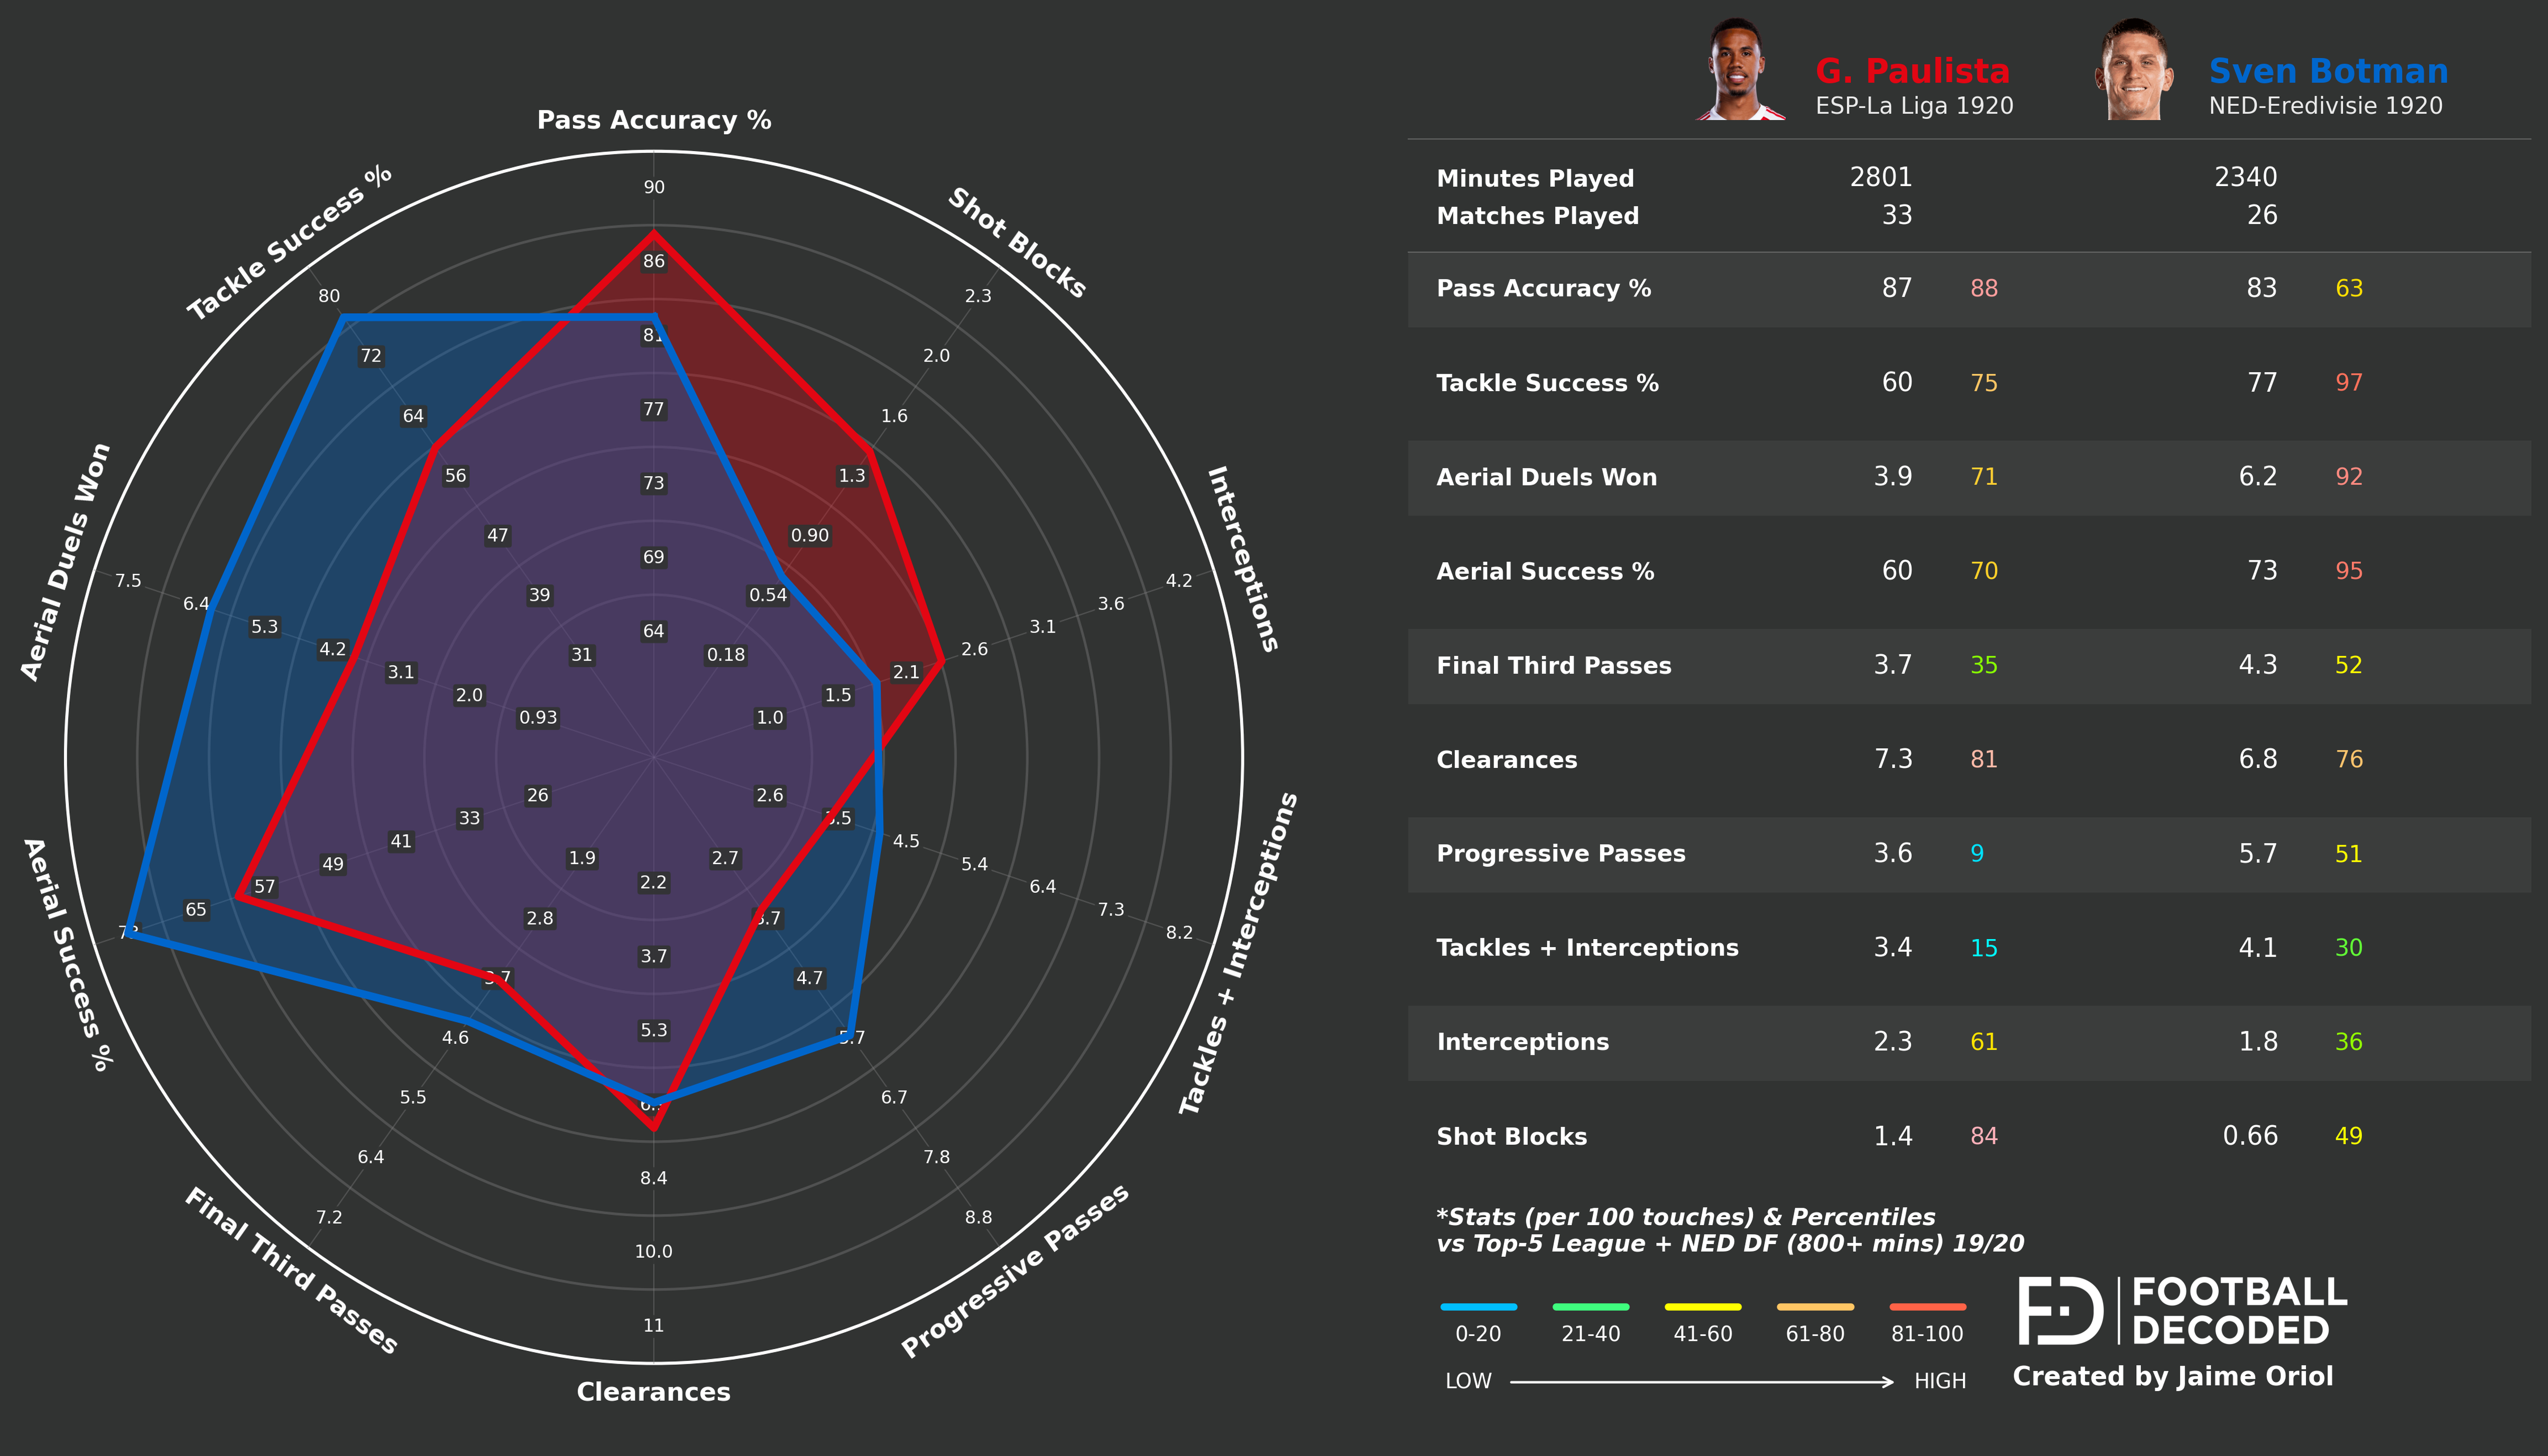


RADAR COMPARISON SUMMARY
✓ Radar generated successfully
Files saved in: ./gabriel_botman_radars/


In [13]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

print("DF PLAYER RADAR GENERATION")
print("=" * 50)

comparison = COMPARISON
config_name = comparison['name']
player1_name = comparison['player1'] 
player2_name = comparison['player2']
title = comparison['title']
faces = comparison['faces']
colors = comparison['colors']
metrics_key = comparison['metrics_key']

print(f"\nProcessing: {title}")

if player1_name not in player_ids or player2_name not in player_ids:
    print(f"Missing player ID")
    print(f"  {player1_name}: {'Found' if player1_name in player_ids else 'Missing'}")
    print(f"  {player2_name}: {'Found' if player2_name in player_ids else 'Missing'}")
else:
    player1_id = player_ids[player1_name]
    player2_id = player_ids[player2_name]
    
    metrics_config = METRICS_BY_POSITION[metrics_key]
    metrics = metrics_config['metrics']
    metric_titles = metrics_config['titles']
    
    # Dataset DF
    position_df = df_final[df_final['position'].str.startswith('DF')].copy()
    position_filter = "DF"
    
    print(f"  Dataset: {position_df.shape[0]} players ({position_filter})")
    
    # Team names
    player1_team = df_final.loc[df_final['unique_player_id'] == player1_id, 'team'].iloc[0]
    player2_team = df_final.loc[df_final['unique_player_id'] == player2_id, 'team'].iloc[0]
    
    team_colors = colors
    team_logos = {}
    if faces[0]:
        team_logos[player1_team] = faces[0]
    if len(faces) > 1 and faces[1]:
        team_logos[player2_team] = faces[1]
    
    print(f"  Teams: {player1_team} vs {player2_team}")
    print(f"  Colors: {colors}")
    
    try:
        create_player_radar(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        create_stats_table(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}{config_name}_table.png",
            footer_text=f"Stats (per 100 touches) & Percentiles\nvs Top-5 League + NED {position_filter} ({MIN_MINUTES}+ mins) 19/20",
            show_plot=False
        )
        
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            table_path=f"{SAVE_PATH_BASE}{config_name}_table.png", 
            output_path=f"{SAVE_PATH_BASE}{config_name}_combined.png"
        )
        
        print(f"  ✓ Completed: {config_name}_combined.png")
        
        display(IPImage(f"{SAVE_PATH_BASE}{config_name}_combined.png"))
        
        print("\n" + "=" * 50)
        print("RADAR COMPARISON SUMMARY")
        print("=" * 50)
        print(f"✓ Radar generated successfully")
        print(f"Files saved in: {SAVE_PATH_BASE}")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()